In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.swa_utils import AveragedModel
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [4]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

train_images = []
train_labels = []
data_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
for batch in data_batches:
    # Load one batch for demonstration (e.g., data_batch_1)
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, batch))
    train_images.append(batch_dict[b'data'])
    train_labels.append(batch_dict[b'labels'])

train_images = np.concatenate((train_images[0], train_images[1], train_images[2], train_images[3], train_images[4]))
train_labels = np.concatenate((train_labels[0], train_labels[1], train_labels[2], train_labels[3], train_labels[4]))

# Reshape the images
train_images = train_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images 
test_images = cifar10_batch[b'data'].astype(np.float32) / 255.0


validation_data = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch')

validation_images = validation_data[b'data']
validation_labels = validation_data[b'labels']

validation_images = validation_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomResizedCrop(32, scale=(0.6, 1.0)),  # First, random cropping to increase variation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Small perspective changes
    transforms.RandomRotation(10),  # Small rotations for robustness
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip is common for CIFAR-10
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Small color changes
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),  # Not crucial but can keep
    transforms.ToTensor(),  # Convert to tensor (0-1 range)
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize last
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize last
])

class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if(self.labels is not None):
            label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        if(self.labels is not None):
            return img, label
        else:
            return img

train_dataset = CustomCIFAR10Dataset(train_images, train_labels, transform=train_transform)
validation_dataset = CustomCIFAR10Dataset(validation_images, validation_labels, transform=test_transform)
test_dataset = CustomCIFAR10Dataset(test_images, transform=test_transform)

trainDataLoader = torch.utils.data.DataLoader(train_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=True)

validationDataLoader = torch.utils.data.DataLoader(validation_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=False)

testDataLoader = torch.utils.data.DataLoader(test_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=False)

In [5]:
data_iter = iter(trainDataLoader)
images, labels = next(data_iter)

# Print the shape and type of the images and labels
print("Shape of images:", images.shape)  # e.g., torch.Size([64, 3, 32, 32])
print("Type of images:", type(images))  # <class 'torch.Tensor'>

print("Shape of labels:", labels.shape)  # e.g., torch.Size([64])
print("Type of labels:", type(labels))  # <class 'torch.Tensor'>

Shape of images: torch.Size([256, 3, 32, 32])
Type of images: <class 'torch.Tensor'>
Shape of labels: torch.Size([256])
Type of labels: <class 'torch.Tensor'>


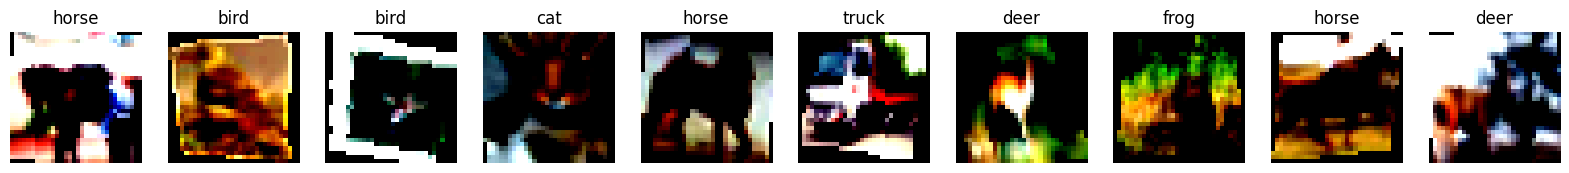

In [6]:
data_iter = iter(trainDataLoader)
images, labels = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.title(label_names[labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

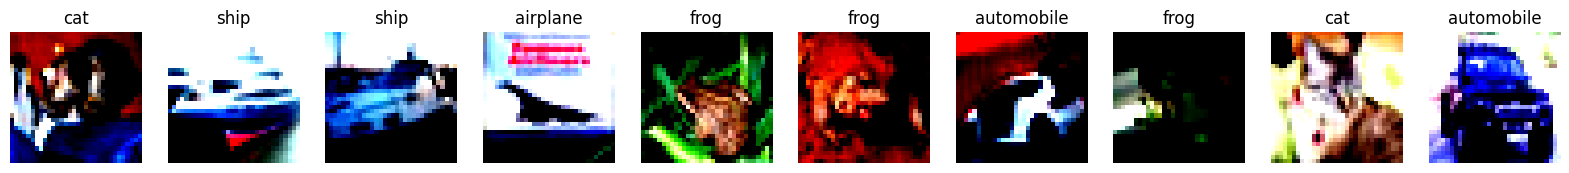

In [7]:
data_iter = iter(validationDataLoader)
images, labels = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.title(label_names[labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

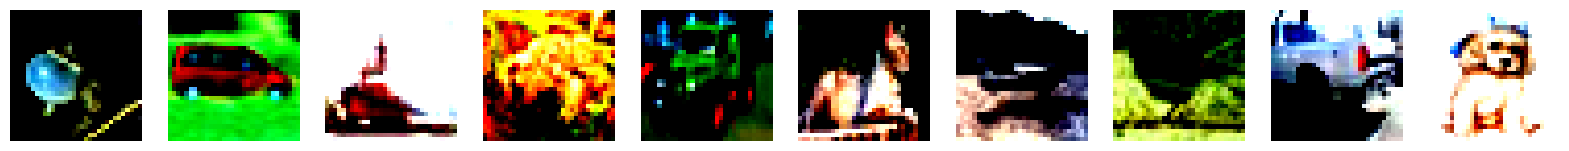

In [8]:
data_iter = iter(testDataLoader)
images = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [9]:
class BuildingBlock(nn.Module):

    
    def __init__(self, in_planes, planes, stride=1):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU()

        self.skip = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)  
        out += self.skip(x) 
        out = self.relu2(out)
        return out


class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(256, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes  # Update input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(BuildingBlock, [4, 4, 3])
model = AveragedModel(model)
model = model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
     BuildingBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [11]:
from tqdm import tqdm

loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 80, 90], gamma=0.1)

train_loss_history = []
val_loss_history = []
train_accuracies = []
val_accuracies = []

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
  train_loss = 0.0
  val_loss = 0.0

  correct = 0
  total = 0
  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    predicted = torch.argmax(predicted_output, dim=1)
    correct += (predicted == labels).sum().item()  # Count correct predictions
    total += labels.size(0)  # Total number of samples
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  train_accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Train Accuracy: {train_accuracy:.2f}%')

  correct = 0
  total = 0
  model.eval()
  for i, data in enumerate(validationDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      predicted_output = model(images)
      predicted = torch.argmax(predicted_output, dim=1)
      correct += (predicted == labels).sum().item()  # Count correct predictions
      total += labels.size(0)  # Total number of samples
      fit = loss(predicted_output, labels)
      val_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  val_loss = val_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  val_loss_history += [val_loss]
  val_accuracy = 100 * correct / total  # Compute accuracy percentage
  train_accuracies += [train_accuracy]
  val_accuracies += [val_accuracy]
  print(f'Val Accuracy: {val_accuracy:.2f}%')
  print(f'Epoch {epoch}, Train loss {train_loss}, val loss {val_loss}')

  scheduler.step()

  0%|          | 0/100 [00:00<?, ?it/s]

Train Accuracy: 27.73%


  1%|          | 1/100 [00:40<1:06:33, 40.34s/it]

Val Accuracy: 36.44%
Epoch 0, Train loss 1.9733971010665505, val loss 1.6848414719104767
Train Accuracy: 42.85%


  2%|▏         | 2/100 [01:19<1:04:48, 39.68s/it]

Val Accuracy: 47.95%
Epoch 1, Train loss 1.5437622581209456, val loss 1.4371982038021087
Train Accuracy: 51.47%


  3%|▎         | 3/100 [01:58<1:03:46, 39.45s/it]

Val Accuracy: 57.42%
Epoch 2, Train loss 1.3356254690763902, val loss 1.1457237988710403
Train Accuracy: 57.89%


  4%|▍         | 4/100 [02:38<1:03:04, 39.43s/it]

Val Accuracy: 63.01%
Epoch 3, Train loss 1.175256176566591, val loss 1.0435795128345489
Train Accuracy: 62.25%


  5%|▌         | 5/100 [03:17<1:02:17, 39.34s/it]

Val Accuracy: 68.24%
Epoch 4, Train loss 1.065683900397651, val loss 0.902828885614872
Train Accuracy: 66.41%


  6%|▌         | 6/100 [03:56<1:01:34, 39.30s/it]

Val Accuracy: 69.02%
Epoch 5, Train loss 0.9560278541579539, val loss 0.9040033727884292
Train Accuracy: 69.49%


  7%|▋         | 7/100 [04:35<1:00:54, 39.30s/it]

Val Accuracy: 72.06%
Epoch 6, Train loss 0.8629020467704657, val loss 0.8059716269373893
Train Accuracy: 72.59%


  8%|▊         | 8/100 [05:15<1:00:12, 39.27s/it]

Val Accuracy: 74.07%
Epoch 7, Train loss 0.7850625320356719, val loss 0.7641402237117291
Train Accuracy: 75.10%


  9%|▉         | 9/100 [05:54<59:31, 39.25s/it]  

Val Accuracy: 77.13%
Epoch 8, Train loss 0.7167162451208854, val loss 0.6489471465349197
Train Accuracy: 76.76%


 10%|█         | 10/100 [06:33<58:56, 39.29s/it]

Val Accuracy: 81.21%
Epoch 9, Train loss 0.665346063825549, val loss 0.545677138119936
Train Accuracy: 78.17%


 11%|█         | 11/100 [07:12<58:17, 39.30s/it]

Val Accuracy: 77.19%
Epoch 10, Train loss 0.6290142121059554, val loss 0.6535761713981628
Train Accuracy: 79.63%


 12%|█▏        | 12/100 [07:52<57:35, 39.27s/it]

Val Accuracy: 81.32%
Epoch 11, Train loss 0.5830838114631419, val loss 0.5547535650432109
Train Accuracy: 80.87%


 13%|█▎        | 13/100 [08:31<56:55, 39.26s/it]

Val Accuracy: 82.53%
Epoch 12, Train loss 0.5507888935354291, val loss 0.520882036536932
Train Accuracy: 82.07%


 14%|█▍        | 14/100 [09:10<56:14, 39.24s/it]

Val Accuracy: 81.99%
Epoch 13, Train loss 0.5166648781421234, val loss 0.5411650814116001
Train Accuracy: 82.95%


 15%|█▌        | 15/100 [09:49<55:35, 39.24s/it]

Val Accuracy: 84.21%
Epoch 14, Train loss 0.49255051098916, val loss 0.4689997710287571
Train Accuracy: 83.56%


 16%|█▌        | 16/100 [10:29<54:55, 39.24s/it]

Val Accuracy: 84.75%
Epoch 15, Train loss 0.4735683623929413, val loss 0.4544105254113674
Train Accuracy: 84.19%


 17%|█▋        | 17/100 [11:08<54:14, 39.21s/it]

Val Accuracy: 85.50%
Epoch 16, Train loss 0.45428343269289756, val loss 0.43734084740281104
Train Accuracy: 85.12%


 18%|█▊        | 18/100 [11:47<53:33, 39.19s/it]

Val Accuracy: 84.45%
Epoch 17, Train loss 0.4307754346910788, val loss 0.4523396410048008
Train Accuracy: 85.70%


 19%|█▉        | 19/100 [12:26<52:53, 39.18s/it]

Val Accuracy: 86.61%
Epoch 18, Train loss 0.4160842626374595, val loss 0.39479011595249175
Train Accuracy: 86.26%


 20%|██        | 20/100 [13:05<52:14, 39.18s/it]

Val Accuracy: 85.10%
Epoch 19, Train loss 0.3954949870097394, val loss 0.44872595369815826
Train Accuracy: 86.68%


 21%|██        | 21/100 [13:44<51:34, 39.17s/it]

Val Accuracy: 86.51%
Epoch 20, Train loss 0.38126322817133396, val loss 0.3992424726486206
Train Accuracy: 87.30%


 22%|██▏       | 22/100 [14:23<50:54, 39.16s/it]

Val Accuracy: 87.24%
Epoch 21, Train loss 0.36395796798929875, val loss 0.3836559809744358
Train Accuracy: 87.67%


 23%|██▎       | 23/100 [15:03<50:13, 39.14s/it]

Val Accuracy: 87.21%
Epoch 22, Train loss 0.3552789268444996, val loss 0.370553781837225
Train Accuracy: 88.51%


 24%|██▍       | 24/100 [15:42<49:34, 39.14s/it]

Val Accuracy: 86.30%
Epoch 23, Train loss 0.3337436829294477, val loss 0.4105523910373449
Train Accuracy: 88.59%


 25%|██▌       | 25/100 [16:21<48:58, 39.18s/it]

Val Accuracy: 88.55%
Epoch 24, Train loss 0.32767448498278245, val loss 0.3381776984781027
Train Accuracy: 88.92%


 26%|██▌       | 26/100 [17:00<48:23, 39.24s/it]

Val Accuracy: 89.18%
Epoch 25, Train loss 0.31888345682195257, val loss 0.3310296779498458
Train Accuracy: 89.14%


 27%|██▋       | 27/100 [17:40<47:46, 39.26s/it]

Val Accuracy: 89.14%
Epoch 26, Train loss 0.3086732229864111, val loss 0.33165710158646106
Train Accuracy: 89.79%


 28%|██▊       | 28/100 [18:19<47:09, 39.30s/it]

Val Accuracy: 88.65%
Epoch 27, Train loss 0.2948347350620494, val loss 0.3404327277094126
Train Accuracy: 89.89%


 29%|██▉       | 29/100 [18:58<46:29, 39.30s/it]

Val Accuracy: 87.68%
Epoch 28, Train loss 0.28775346301952187, val loss 0.3653352685272694
Train Accuracy: 89.98%


 30%|███       | 30/100 [19:38<45:53, 39.33s/it]

Val Accuracy: 89.15%
Epoch 29, Train loss 0.2839527333117261, val loss 0.3210615985095501
Train Accuracy: 92.94%


 31%|███       | 31/100 [20:17<45:11, 39.29s/it]

Val Accuracy: 91.67%
Epoch 30, Train loss 0.20673215948045254, val loss 0.24861203618347644
Train Accuracy: 94.01%


 32%|███▏      | 32/100 [20:56<44:28, 39.24s/it]

Val Accuracy: 91.85%
Epoch 31, Train loss 0.1736457387403566, val loss 0.24712782725691795
Train Accuracy: 94.46%


 33%|███▎      | 33/100 [21:35<43:45, 39.19s/it]

Val Accuracy: 92.08%
Epoch 32, Train loss 0.16310567192125078, val loss 0.2433531481772661
Train Accuracy: 94.63%


 34%|███▍      | 34/100 [22:14<43:05, 39.17s/it]

Val Accuracy: 92.42%
Epoch 33, Train loss 0.15684873302828292, val loss 0.24153235964477063
Train Accuracy: 94.54%


 35%|███▌      | 35/100 [22:54<42:30, 39.23s/it]

Val Accuracy: 92.33%
Epoch 34, Train loss 0.15524680650203812, val loss 0.23720826171338558
Train Accuracy: 95.03%


 36%|███▌      | 36/100 [23:33<41:48, 39.19s/it]

Val Accuracy: 92.21%
Epoch 35, Train loss 0.14563095611425078, val loss 0.23874351158738136
Train Accuracy: 95.01%


 37%|███▋      | 37/100 [24:12<41:07, 39.16s/it]

Val Accuracy: 92.34%
Epoch 36, Train loss 0.140976950640277, val loss 0.2355583943426609
Train Accuracy: 95.34%


 38%|███▊      | 38/100 [24:51<40:27, 39.16s/it]

Val Accuracy: 92.15%
Epoch 37, Train loss 0.13629816514344847, val loss 0.24167039841413498
Train Accuracy: 95.40%


 39%|███▉      | 39/100 [25:30<39:47, 39.15s/it]

Val Accuracy: 92.28%
Epoch 38, Train loss 0.13296985451360138, val loss 0.23660469092428685
Train Accuracy: 95.55%


 40%|████      | 40/100 [26:09<39:08, 39.15s/it]

Val Accuracy: 92.17%
Epoch 39, Train loss 0.13146517883834183, val loss 0.23452358543872834
Train Accuracy: 95.68%


 41%|████      | 41/100 [26:48<38:29, 39.14s/it]

Val Accuracy: 92.31%
Epoch 40, Train loss 0.12387579778323368, val loss 0.2407293576747179
Train Accuracy: 95.69%


 42%|████▏     | 42/100 [27:27<37:49, 39.13s/it]

Val Accuracy: 92.56%
Epoch 41, Train loss 0.1261630277244412, val loss 0.2366122415289283
Train Accuracy: 95.81%


 43%|████▎     | 43/100 [28:07<37:10, 39.12s/it]

Val Accuracy: 92.56%
Epoch 42, Train loss 0.12008816990241104, val loss 0.23967911005020143
Train Accuracy: 96.03%


 44%|████▍     | 44/100 [28:46<36:32, 39.15s/it]

Val Accuracy: 92.30%
Epoch 43, Train loss 0.11665866178061281, val loss 0.24174791127443312
Train Accuracy: 95.96%


 45%|████▌     | 45/100 [29:25<35:52, 39.14s/it]

Val Accuracy: 92.54%
Epoch 44, Train loss 0.11682253444985467, val loss 0.23713434897363186
Train Accuracy: 95.99%


 46%|████▌     | 46/100 [30:04<35:14, 39.15s/it]

Val Accuracy: 92.26%
Epoch 45, Train loss 0.11453993859871918, val loss 0.2436980988830328
Train Accuracy: 95.92%


 47%|████▋     | 47/100 [30:43<34:35, 39.16s/it]

Val Accuracy: 92.48%
Epoch 46, Train loss 0.11486350988246957, val loss 0.240331319719553
Train Accuracy: 96.25%


 48%|████▊     | 48/100 [31:22<33:56, 39.16s/it]

Val Accuracy: 92.60%
Epoch 47, Train loss 0.1109936582684821, val loss 0.23819689489901066
Train Accuracy: 96.32%


 49%|████▉     | 49/100 [32:02<33:16, 39.15s/it]

Val Accuracy: 92.52%
Epoch 48, Train loss 0.10568774485846563, val loss 0.24130752198398114
Train Accuracy: 96.37%


 50%|█████     | 50/100 [32:41<32:36, 39.12s/it]

Val Accuracy: 92.53%
Epoch 49, Train loss 0.10527621812130115, val loss 0.24087613970041274
Train Accuracy: 96.56%


 51%|█████     | 51/100 [33:20<31:56, 39.12s/it]

Val Accuracy: 92.65%
Epoch 50, Train loss 0.10035457935336294, val loss 0.24305929690599443
Train Accuracy: 96.55%


 52%|█████▏    | 52/100 [33:59<31:17, 39.12s/it]

Val Accuracy: 92.76%
Epoch 51, Train loss 0.09774557468766461, val loss 0.2427985593676567
Train Accuracy: 96.58%


 53%|█████▎    | 53/100 [34:38<30:38, 39.13s/it]

Val Accuracy: 92.73%
Epoch 52, Train loss 0.09984498653484851, val loss 0.23719062190502882
Train Accuracy: 96.78%


 54%|█████▍    | 54/100 [35:18<30:07, 39.30s/it]

Val Accuracy: 92.56%
Epoch 53, Train loss 0.09212711489550313, val loss 0.24639947675168514
Train Accuracy: 96.72%


 55%|█████▌    | 55/100 [35:57<29:26, 39.26s/it]

Val Accuracy: 92.77%
Epoch 54, Train loss 0.09351230405119, val loss 0.24582315124571325
Train Accuracy: 96.88%


 56%|█████▌    | 56/100 [36:36<28:45, 39.22s/it]

Val Accuracy: 92.59%
Epoch 55, Train loss 0.09251271716642137, val loss 0.24448016583919524
Train Accuracy: 96.96%


 57%|█████▋    | 57/100 [37:15<28:05, 39.20s/it]

Val Accuracy: 92.64%
Epoch 56, Train loss 0.09080401572341822, val loss 0.24388906173408031
Train Accuracy: 96.83%


 58%|█████▊    | 58/100 [37:54<27:26, 39.19s/it]

Val Accuracy: 92.51%
Epoch 57, Train loss 0.09266703929371979, val loss 0.24426808375865222
Train Accuracy: 96.87%


 59%|█████▉    | 59/100 [38:33<26:45, 39.16s/it]

Val Accuracy: 92.53%
Epoch 58, Train loss 0.09045629246084362, val loss 0.243752059340477
Train Accuracy: 97.11%


 60%|██████    | 60/100 [39:12<26:05, 39.13s/it]

Val Accuracy: 92.43%
Epoch 59, Train loss 0.08573218617512256, val loss 0.2481133934110403
Train Accuracy: 97.19%


 61%|██████    | 61/100 [39:52<25:25, 39.12s/it]

Val Accuracy: 92.52%
Epoch 60, Train loss 0.0821468451687572, val loss 0.24357860013842583
Train Accuracy: 97.39%


 62%|██████▏   | 62/100 [40:31<24:46, 39.12s/it]

Val Accuracy: 92.75%
Epoch 61, Train loss 0.07685566537690405, val loss 0.24229512140154838
Train Accuracy: 97.34%


 63%|██████▎   | 63/100 [41:10<24:07, 39.12s/it]

Val Accuracy: 92.77%
Epoch 62, Train loss 0.07640815404604892, val loss 0.23860868476331235
Train Accuracy: 97.43%


 64%|██████▍   | 64/100 [41:49<23:27, 39.11s/it]

Val Accuracy: 92.72%
Epoch 63, Train loss 0.07474816816725902, val loss 0.23866496421396732
Train Accuracy: 97.41%


 65%|██████▌   | 65/100 [42:28<22:48, 39.10s/it]

Val Accuracy: 92.80%
Epoch 64, Train loss 0.07461706737094388, val loss 0.24126417115330695
Train Accuracy: 97.63%


 66%|██████▌   | 66/100 [43:07<22:09, 39.11s/it]

Val Accuracy: 92.78%
Epoch 65, Train loss 0.07231250513649108, val loss 0.23867652341723442
Train Accuracy: 97.47%


 67%|██████▋   | 67/100 [43:46<21:30, 39.09s/it]

Val Accuracy: 92.82%
Epoch 66, Train loss 0.07436138579659925, val loss 0.23663459941744805
Train Accuracy: 97.61%


 68%|██████▊   | 68/100 [44:25<20:52, 39.15s/it]

Val Accuracy: 92.84%
Epoch 67, Train loss 0.07222949924441624, val loss 0.23797044306993484
Train Accuracy: 97.56%


 69%|██████▉   | 69/100 [45:05<20:13, 39.14s/it]

Val Accuracy: 92.79%
Epoch 68, Train loss 0.07259575596877507, val loss 0.23905114755034446
Train Accuracy: 97.63%


 70%|███████   | 70/100 [45:44<19:34, 39.14s/it]

Val Accuracy: 92.92%
Epoch 69, Train loss 0.07170934963743297, val loss 0.2377515435218811
Train Accuracy: 97.54%


 71%|███████   | 71/100 [46:23<18:55, 39.14s/it]

Val Accuracy: 92.80%
Epoch 70, Train loss 0.07255531392269293, val loss 0.24005434699356556
Train Accuracy: 97.57%


 72%|███████▏  | 72/100 [47:02<18:15, 39.13s/it]

Val Accuracy: 92.81%
Epoch 71, Train loss 0.07192777669323343, val loss 0.2378477703779936
Train Accuracy: 97.66%


 73%|███████▎  | 73/100 [47:41<17:36, 39.14s/it]

Val Accuracy: 92.86%
Epoch 72, Train loss 0.06999459256399043, val loss 0.23913103081285952
Train Accuracy: 97.60%


 74%|███████▍  | 74/100 [48:20<16:57, 39.14s/it]

Val Accuracy: 92.94%
Epoch 73, Train loss 0.07118177637267782, val loss 0.23884122595191
Train Accuracy: 97.62%


 75%|███████▌  | 75/100 [48:59<16:18, 39.15s/it]

Val Accuracy: 93.02%
Epoch 74, Train loss 0.06987586628873738, val loss 0.23786348663270473
Train Accuracy: 97.77%


 76%|███████▌  | 76/100 [49:39<15:39, 39.14s/it]

Val Accuracy: 92.99%
Epoch 75, Train loss 0.06677010994195481, val loss 0.2378250565379858
Train Accuracy: 97.85%


 77%|███████▋  | 77/100 [50:18<14:59, 39.13s/it]

Val Accuracy: 92.90%
Epoch 76, Train loss 0.06644916051656616, val loss 0.23745304420590402
Train Accuracy: 97.61%


 78%|███████▊  | 78/100 [50:57<14:20, 39.10s/it]

Val Accuracy: 92.99%
Epoch 77, Train loss 0.0701830653967906, val loss 0.23780806213617325
Train Accuracy: 97.61%


 79%|███████▉  | 79/100 [51:36<13:40, 39.09s/it]

Val Accuracy: 92.86%
Epoch 78, Train loss 0.06767500347780939, val loss 0.2371629945933819
Train Accuracy: 97.61%


 80%|████████  | 80/100 [52:15<13:02, 39.10s/it]

Val Accuracy: 93.12%
Epoch 79, Train loss 0.07066196086341325, val loss 0.23588804602622987
Train Accuracy: 97.65%


 81%|████████  | 81/100 [52:54<12:22, 39.10s/it]

Val Accuracy: 93.03%
Epoch 80, Train loss 0.06864402019323743, val loss 0.2368768859654665
Train Accuracy: 97.80%


 82%|████████▏ | 82/100 [53:33<11:43, 39.10s/it]

Val Accuracy: 93.04%
Epoch 81, Train loss 0.06730187864860102, val loss 0.23736733794212342
Train Accuracy: 97.70%


 83%|████████▎ | 83/100 [54:12<11:04, 39.09s/it]

Val Accuracy: 92.97%
Epoch 82, Train loss 0.06782178162616126, val loss 0.2366067174822092
Train Accuracy: 97.73%


 84%|████████▍ | 84/100 [54:51<10:25, 39.09s/it]

Val Accuracy: 93.00%
Epoch 83, Train loss 0.06714633026407385, val loss 0.23548836410045623
Train Accuracy: 97.56%


 85%|████████▌ | 85/100 [55:30<09:46, 39.09s/it]

Val Accuracy: 92.95%
Epoch 84, Train loss 0.06956488566891271, val loss 0.23706293739378453
Train Accuracy: 97.80%


 86%|████████▌ | 86/100 [56:09<09:07, 39.12s/it]

Val Accuracy: 92.97%
Epoch 85, Train loss 0.06537153870247457, val loss 0.23628380261361598
Train Accuracy: 97.82%


 87%|████████▋ | 87/100 [56:49<08:29, 39.16s/it]

Val Accuracy: 92.99%
Epoch 86, Train loss 0.0651692858878143, val loss 0.23747552931308746
Train Accuracy: 97.71%


 88%|████████▊ | 88/100 [57:28<07:49, 39.15s/it]

Val Accuracy: 92.98%
Epoch 87, Train loss 0.06716577184139466, val loss 0.23624511063098907
Train Accuracy: 97.80%


 89%|████████▉ | 89/100 [58:07<07:10, 39.14s/it]

Val Accuracy: 92.93%
Epoch 88, Train loss 0.06499997003726204, val loss 0.23546714782714845
Train Accuracy: 97.76%


 90%|█████████ | 90/100 [58:46<06:31, 39.14s/it]

Val Accuracy: 92.91%
Epoch 89, Train loss 0.06672946089992718, val loss 0.2363688074052334
Train Accuracy: 97.69%


 91%|█████████ | 91/100 [59:25<05:52, 39.13s/it]

Val Accuracy: 92.97%
Epoch 90, Train loss 0.06692226362243599, val loss 0.23490532375872136
Train Accuracy: 97.70%


 92%|█████████▏| 92/100 [1:00:05<05:13, 39.19s/it]

Val Accuracy: 93.01%
Epoch 91, Train loss 0.06933432631194592, val loss 0.2363631509244442
Train Accuracy: 97.78%


 93%|█████████▎| 93/100 [1:00:44<04:34, 39.21s/it]

Val Accuracy: 93.03%
Epoch 92, Train loss 0.06599985406144845, val loss 0.2378312699496746
Train Accuracy: 97.74%


 94%|█████████▍| 94/100 [1:01:23<03:55, 39.23s/it]

Val Accuracy: 92.88%
Epoch 93, Train loss 0.06691716434624122, val loss 0.2356691800057888
Train Accuracy: 97.92%


 95%|█████████▌| 95/100 [1:02:02<03:16, 39.22s/it]

Val Accuracy: 92.94%
Epoch 94, Train loss 0.06439429613742598, val loss 0.23611295260488988
Train Accuracy: 97.70%


 96%|█████████▌| 96/100 [1:02:42<02:37, 39.27s/it]

Val Accuracy: 92.96%
Epoch 95, Train loss 0.06680906388186375, val loss 0.23642522394657134
Train Accuracy: 97.73%


 97%|█████████▋| 97/100 [1:03:21<01:57, 39.28s/it]

Val Accuracy: 92.98%
Epoch 96, Train loss 0.06669865211243836, val loss 0.2352828286588192
Train Accuracy: 97.81%


 98%|█████████▊| 98/100 [1:04:00<01:18, 39.29s/it]

Val Accuracy: 92.89%
Epoch 97, Train loss 0.06615108025393315, val loss 0.2362237200140953
Train Accuracy: 97.72%


 99%|█████████▉| 99/100 [1:04:40<00:39, 39.31s/it]

Val Accuracy: 92.90%
Epoch 98, Train loss 0.06686120256971644, val loss 0.23698299564421177
Train Accuracy: 97.68%


100%|██████████| 100/100 [1:05:19<00:00, 39.19s/it]

Val Accuracy: 93.11%
Epoch 99, Train loss 0.06902050126191912, val loss 0.23710440397262572


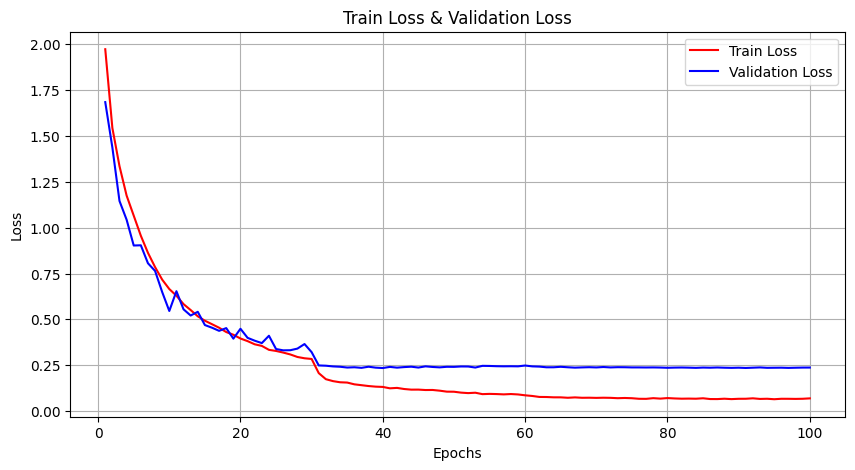

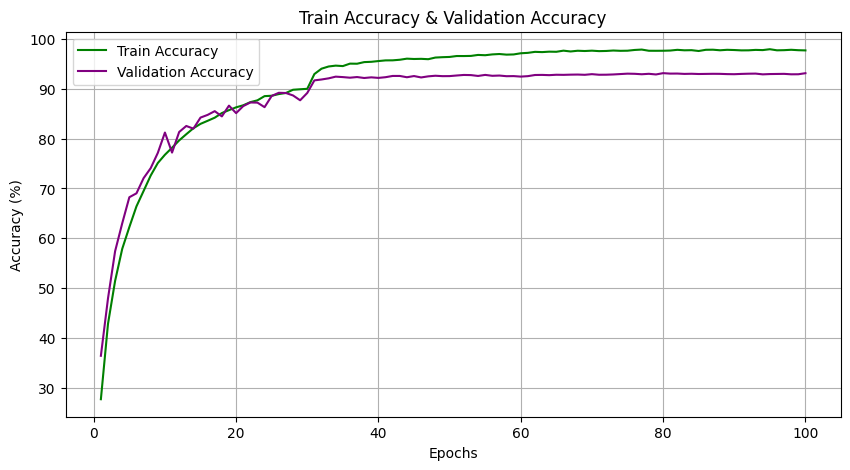

In [12]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss', color='red')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss & Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [13]:
model.eval()
predictions = []
with torch.no_grad():
    for images in testDataLoader:
        images = images.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved.")

Submission file saved.


In [14]:
torch.save(model.state_dict(), "model_weights.pth")

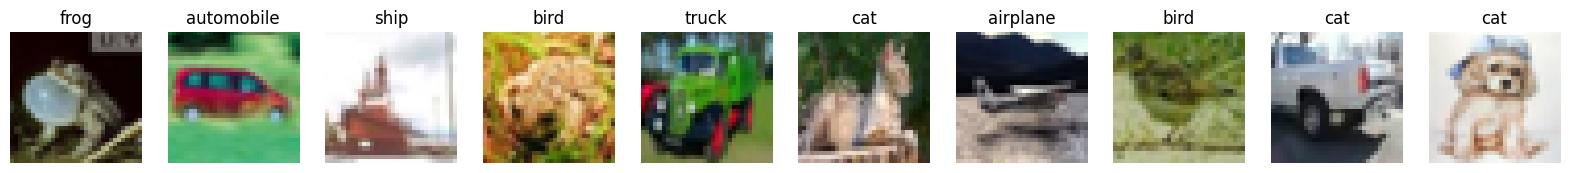

In [15]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    images = torch.tensor(test_images[i], dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
    images = images.permute(2, 0, 1).unsqueeze(0).to(device)  # Add batch dimension and move to device
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1).item()  # Extract the prediction
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[i])  # Original image format for visualization
    plt.title(label_names[predicted].decode('utf-8'))  # Show predicted label as title
    plt.axis('off')

plt.show()